In [1]:
#importing libraries
from data_loader_2 import FootballDataLoader2
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import (
    Input, Masking, GRU, Dense, Dropout, TimeDistributed, RepeatVector
)
import matplotlib.pyplot as plt
import shap
from sklearn.metrics import mean_squared_error

In [2]:
#loading data
#Getting the data
data_dir = r"\Users\kirlo\Documents\Sanvi University Work\Year 3\AML\final project\FootballData\RestructuredData_2425"  # replace with your actual data directory
team = "FCK"         
data_retriever = FootballDataLoader2(data_dir, team)
all_games = data_retriever.load_all_games(n_games='all', speed_player= False, speed_ball=False, player_z=False, ball_z = True, )  


Reading game 1: Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Loading Game_FCK_RFC_Score_1_1_Day_2024-08-04Z.pkl
Data read.
Time shape: (155541, 2)
Ball shape: (155541, 4)
Team shape: (155541, 45)
Opponent shape: (155541, 48)
Total shape: (78147, 99)
Opponent name detected from filename: RFC
Reading game 2: Game_FCK_VFF_Score_1_1_Day_2024-08-18Z.pkl
Loading Game_FCK_VFF_Score_1_1_Day_2024-08-18Z.pkl
Data read.
Time shape: (158121, 2)
Ball shape: (158121, 4)
Team shape: (158121, 48)
Opponent shape: (158121, 48)
Total shape: (75804, 102)
Opponent name detected from filename: VFF
Reading game 3: Game_FCN_FCK_Score_3_2_Day_2024-08-25Z.pkl
Loading Game_FCN_FCK_Score_3_2_Day_2024-08-25Z.pkl
Data read.
Time shape: (148646, 2)
Ball shape: (148646, 4)
Team shape: (148646, 48)
Opponent shape: (148646, 48)
Total shape: (70604, 102)
Opponent name detected from filename: FCN
Reading game 4: Game_FCK_SIF_Score_2_2_Day_2024-11-04Z.pkl
Loading Game_FCK_SIF_Score_2_2_Day_2024-11-04Z.pkl
Data read.
Time sh

In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shap
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Masking
from tensorflow.keras.callbacks import EarlyStopping

all_shap_results = []

for game_idx, game in enumerate(all_games):
    print(f"Processing game {game_idx+1}/{len(all_games)}")

    #reduce
    cols = ['Ball_x', 'Ball_y', 'Ball_z'] + [col for col in game.columns if ('player' in col and (col.endswith('_x') or col.endswith('_y')))]
    game = game[cols]

    #normalise
    scaler = StandardScaler()
    game_scaled = pd.DataFrame(
        scaler.fit_transform(game),
        columns=game.columns,
        index=game.index
    )
    pad_value = 0.0
    game_scaled = np.nan_to_num(game_scaled, nan=pad_value)

    # Get column indices
    feature_columns = [col for col in game.columns if col not in ['Ball_x', 'Ball_y']]
    target_cols = ['Ball_x', 'Ball_y']
    target_indices = [game.columns.get_loc(col) for col in target_cols]
    feature_indices = [game.columns.get_loc(col) for col in feature_columns]

    game_np = game_scaled
    sequence_length = 10

    X, y = [], []
    for i in range(len(game_np) - sequence_length):
        X.append(game_np[i:i+sequence_length, feature_indices])
        y.append(game_np[i + sequence_length, target_indices])

    X, y = np.array(X), np.array(y)
    if len(X) < 10:
        print(f"Skipping game {game_idx+1} due to insufficient sequences.")
        continue

    
    model = Sequential([
        Masking(mask_value=pad_value, input_shape=(X.shape[1], X.shape[2])),
        GRU(64, return_sequences=False),
        Dense(2, activation='linear')
    ])
    model.compile(optimizer='adam', loss='mse')

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    model.fit(X_train, y_train, epochs=20, batch_size=32, validation_split=0.2, callbacks=[early_stopping], verbose=0)

    #doing shaps
    X_test_flat = X_test.reshape(X_test.shape[0], -1)
    X_train_flat = X_train.reshape(X_train.shape[0], -1)

    def model_predict_flat(x_flat):
        x_seq = x_flat.reshape((x_flat.shape[0], X.shape[1], X.shape[2]))
        return model.predict(x_seq, verbose=0)

    background_flat = X_train_flat[np.random.choice(X_train_flat.shape[0], min(100, len(X_train_flat)), replace=False)]
    explainer = shap.Explainer(model_predict_flat, background_flat)
    X_sample_flat = X_test_flat[:10]
    shap_values = explainer(X_sample_flat, max_evals= 941)

    shap_values_mean = np.abs(shap_values.values).mean(axis=0)

    T, N = X.shape[1], X.shape[2]
    feature_names = [f"t{t}_f{f}" for t in range(T) for f in range(N)]

    player_importance = {}
    for f_idx, feat_name in enumerate(feature_names):
        t = f_idx // N
        f = f_idx % N
        player_feat = feature_columns[f]
        player = player_feat if player_feat == "Ball_z" else player_feat.rsplit("_", 1)[0]
        if player not in player_importance:
            player_importance[player] = np.zeros(shap_values_mean[f_idx].shape)
        player_importance[player] += shap_values_mean[f_idx]

    game_shap_df = pd.DataFrame(
        [(k, np.mean(v)) for k, v in player_importance.items()], #finding mean shap
        columns=["player", "shap_importance"]
    ).sort_values("shap_importance", ascending=False)

    game_shap_df['game'] = game_idx + 1
    all_shap_results.append(game_shap_df)
def filter_pred_by_list(pred_df, player_list, team_prefix):
    # Keep only rows where player number is in the team list
    def player_in_list(player):
        if player.startswith(team_prefix):
            try:
                num = int(player.split('_')[1])
                return num in player_list
            except (IndexError, ValueError):
                return False
        return True  # keep other teams' players
    return pred_df[pred_df['player'].apply(player_in_list)].reset_index(drop=True)
FCK = [41,1,31,5,2,6,4,20,24,15,13,22,36,8,12,17,27,33,38,48,30,16,40,10,11,7,14,19]
FCK_pred = filter_pred_by_list(all_shap_results, FCK, "FCKplayer_")
#putting all the shaps together
combined_shap_df = pd.concat(FCK_pred, ignore_index=True)

#making plots
for game_id in combined_shap_df['game'].unique():
    df = combined_shap_df[combined_shap_df['game'] == game_id]
    plt.figure(figsize=(12, 5))
    plt.bar(df['player'], df['shap_importance'])
    plt.xticks(rotation=90)
    plt.ylabel('Mean SHAP Value')
    plt.title(f'SHAP Importance - Game {game_id}')
    plt.tight_layout()
    plt.show()


NameError: name 'all_games' is not defined

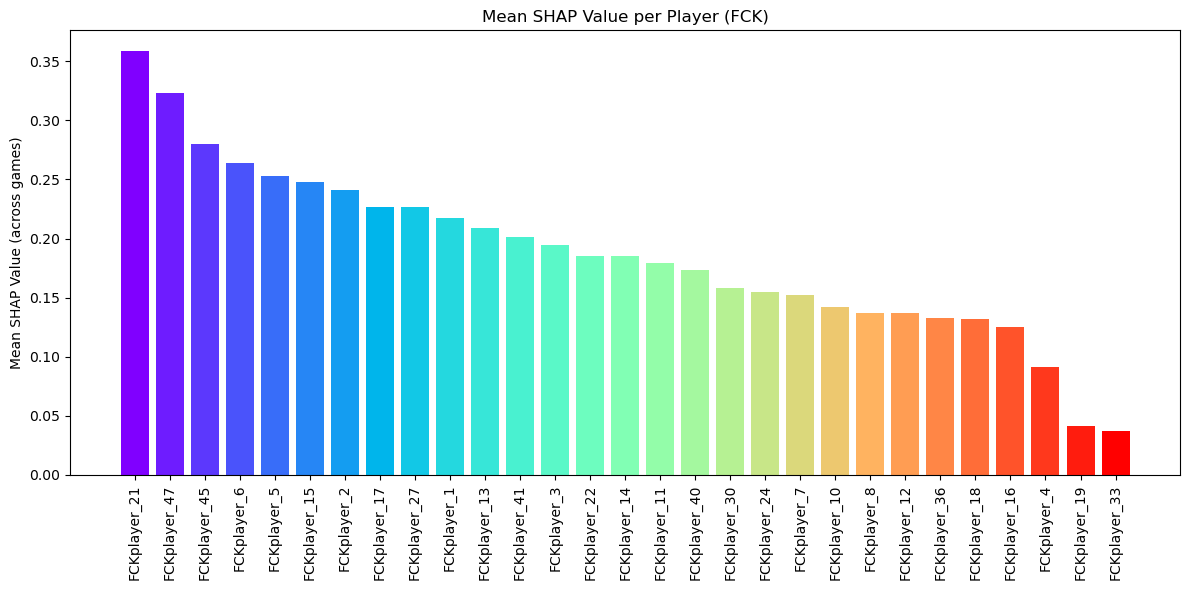

In [20]:

all_shap = combined_shap_df #didnt want to change all the later lines

#just the fck players
all_shap = all_shap[all_shap['player'].str.startswith('FCKplayer_')]

#mean shaps across all games
mean_shap = all_shap.groupby('player')['shap_importance'].mean().reset_index()


mean_shap = mean_shap.sort_values('shap_importance', ascending=False)

# Plot
plt.figure(figsize=(12, 6))
colors = plt.cm.rainbow(np.linspace(0, 1, len(mean_shap)))
plt.bar(mean_shap['player'], mean_shap['shap_importance'], color=colors)
plt.xticks(rotation=90)
plt.ylabel('Mean SHAP Value (across games)')
plt.title('Mean SHAP Value per Player (FCK)')
plt.tight_layout()
plt.show()

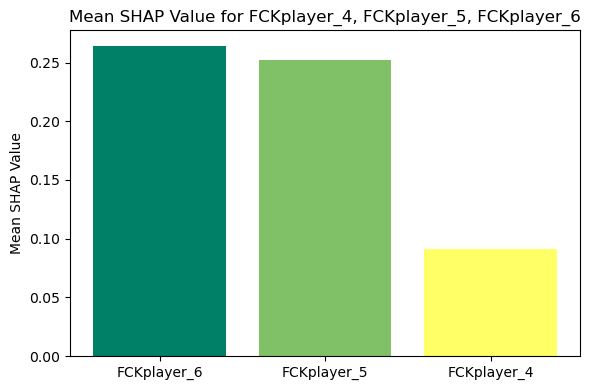

In [ ]:
mean_shap[mean_shap['player'].isin(['FCKplayer_4', 'FCKplayer_5', 'FCKplayer_6'])]


subset = mean_shap[mean_shap['player'].isin(['FCKplayer_4', 'FCKplayer_5', 'FCKplayer_6'])]
plt.figure(figsize=(6, 4))
plt.bar(subset['player'], subset['shap_importance'], color='skyblue')
plt.ylabel('Mean SHAP Value')
plt.title('Mean SHAP Value for FCKplayer_4, FCKplayer_5, FCKplayer_6')
plt.tight_layout()
plt.bar(subset['player'], subset['shap_importance'], color=plt.cm.greens(np.linspace(0, 1, len(subset))))
plt.show()

In [26]:
print(mean_shap[mean_shap['player'] == 'FCKplayer_2'])

         player  shap_importance
11  FCKplayer_2         0.241244
